## Train Model

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import os

# --- 1. SYSTEM CONFIG ---
SAVE = r"/content/drive/MyDrive/Final Year Project/Battery_DL_Dataset"
BATCH_SIZE = 8
EPOCHS = 30 # Maximum limit; EarlyStopping will likely trigger sooner

# --- 2. LOAD DATA (RAM-Safe Mode) ---
print("Loading data from disk...")
X_train = np.load(os.path.join(SAVE, "X_train.npy"), mmap_mode='r')
y_train = np.load(os.path.join(SAVE, "y_train.npy"), mmap_mode='r')
X_val = np.load(os.path.join(SAVE, "X_val.npy"), mmap_mode='r')
y_val = np.load(os.path.join(SAVE, "y_val.npy"), mmap_mode='r')

# --- 3. DATA GENERATOR (Smooth Feeding) ---
def data_generator(X, y, batch_size):
    indices = np.arange(len(X))
    while True:
        np.random.shuffle(indices)
        for i in range(0, len(X), batch_size):
            batch_indices = indices[i:i+batch_size]
            # Convert slice to actual numpy array in RAM for the GPU
            yield np.array(X[batch_indices]), np.array(y[batch_indices])

# --- 4. THE ARCHITECTURE (ConvLSTM) ---
inputs = Input(shape=(8, 96, 96, 3))

# Feature Extractor: MobileNetV2
# We do NOT pool here (include_top=False) to preserve spatial grid (3x3 feature map)
base = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(96,96,3),
    alpha=0.75
)
base.trainable = False

# Wrap CNN in TimeDistributed to apply it to every frame in the sequence
# Output shape: (Batch, 8, 3, 3, 1280) -> Preserves (Time, Height, Width, Features)
x = TimeDistributed(base)(inputs)

# ConvLSTM Layer: Replaces the GRU
# This tracks how features move/expand spatially over time (perfect for heat spread)
# return_sequences=False: We only care about the battery state at the final timestep
x = ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding='same',
    return_sequences=False,
    dropout=0.3,
    recurrent_dropout=0.2
)(x)

# Output of ConvLSTM is (Batch, 3, 3, 64). We pool this now.
x = GlobalAveragePooling2D()(x)

# Classifier Head
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall')])

# --- 5. THE BRAINS (Callbacks) ---
# These ensure we don't overfit and that we save the BEST version, regardless of the epoch number
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,           # Gives the model 6 chances to recover from a "bad" epoch
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,           # Slashes LR to fine-tune when progress slows
        patience=3,           # Waits 3 epochs before cutting speed
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(SAVE, "best_battery_checkpoint_convlstm.h5"),
        monitor='val_loss',
        save_best_only=True   # Extra safety: saves the file immediately when a new record is hit
    )
]

# --- 6. EXECUTION ---
print("🚀 Training starting. Ensure laptop is plugged in and Sleep Mode is OFF.")
try:
    model.fit(
        data_generator(X_train, y_train, BATCH_SIZE),
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        validation_data=data_generator(X_val, y_val, BATCH_SIZE),
        validation_steps=len(X_val) // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=callbacks
    )
except KeyboardInterrupt:
    print("\nTraining manually stopped. The best weights should still be in memory.")

# --- 7. FINAL SAVE ---
model.save(os.path.join(SAVE, "battery_model_final_convlstm.h5"))
print(f"\n✅ SUCCESS: Model saved to {SAVE}")

Loading data from disk...
5903360/5903360 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
🚀 Training starting. Ensure laptop is plugged in and Sleep Mode is OFF.
Epoch 1/30
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8715 - loss: 0.2817 - recall: 0.8642

2003/2003 ━━━━━━━━━━━━━━━━━━━━ 492s 213ms/step - accuracy: 0.8715 - loss: 0.2816 - recall: 0.8642 - val_accuracy: 0.8899 - val_loss: 0.3171 - val_recall: 0.8510 - learning_rate: 1.0000e-04
Epoch 2/30
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 205s 87ms/step - accuracy: 0.9531 - loss: 0.1188 - recall: 0.9516 - val_accuracy: 0.8666 - val_loss: 0.5363 - val_recall: 0.7881 - learning_rate: 1.0000e-04
Epoch 3/30
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 181s 91ms/step - accuracy: 0.9632 - loss: 0.0917 - recall: 0.9649 - val_accuracy: 0.8601 - val_loss: 0.3982 - val_recall: 0.8031 - learning_rate: 1.0000e-04
Epoch 4/30
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9714 - loss: 0.0807 - recall: 0.9714
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 154s 77ms/step - accuracy: 0.9714 - loss: 0.0807 - recall: 0.9714 - val_accuracy: 0.8638 - val_loss: 0.5517 - val_recall: 0.7990 - learning_rate: 1.0000e-04
Epoch 5/30
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 


✅ SUCCESS: Model saved to /content/drive/MyDrive/Final Year Project/Battery_DL_Dataset


## Evaluation

Loading model: battery_model_final_convlstm.h5...


Model loaded successfully.
Loading validation data...
Generating predictions... (This might take a moment due to ConvLSTM complexity)
436/436 ━━━━━━━━━━━━━━━━━━━━ 78s 104ms/step

--- FINAL CLASSIFICATION REPORT (ConvLSTM) ---
                 precision    recall  f1-score   support

           Safe       0.86      0.93      0.89      1725
Thermal Runaway       0.93      0.85      0.89      1760

       accuracy                           0.89      3485
      macro avg       0.89      0.89      0.89      3485
   weighted avg       0.89      0.89      0.89      3485

Confusion Matrix saved as 'confusion_matrix_convlstm_proof.png'


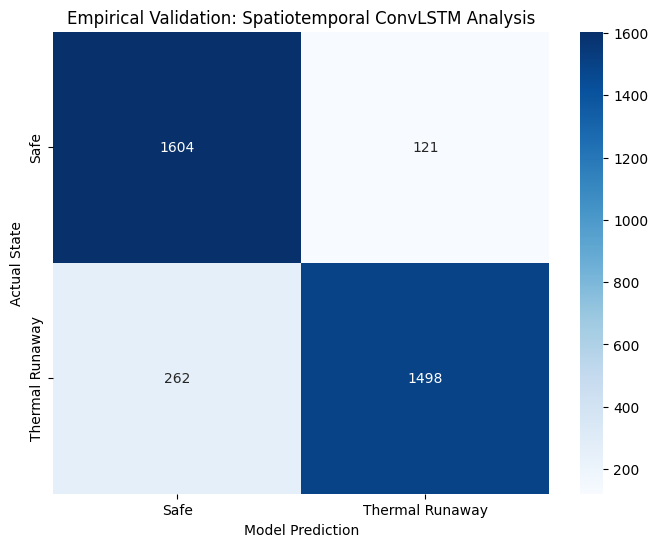

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

# 1. SET YOUR PATHS
SAVE_PATH = r"/content/drive/MyDrive/Final Year Project/Battery_DL_Dataset"
# UPDATED: Pointing to the ConvLSTM model we just defined
MODEL_NAME = "battery_model_final_convlstm.h5"

# 2. LOAD EVERYTHING
print(f"Loading model: {MODEL_NAME}...")
# Note: X_val and y_val must be the same shape as used in training (Batch, 8, 96, 96, 3)
model = tf.keras.models.load_model(os.path.join(SAVE_PATH, MODEL_NAME))
print("Model loaded successfully.")

print("Loading validation data...")
# If you run out of RAM here, you can add mmap_mode='r' inside np.load()
X_val = np.load(os.path.join(SAVE_PATH, "X_val.npy"))
y_val = np.load(os.path.join(SAVE_PATH, "y_val.npy"))

# 3. GENERATE PREDICTIONS
print("Generating predictions... (This might take a moment due to ConvLSTM complexity)")
y_pred_probs = model.predict(X_val, batch_size=8) # Added batch_size to prevent OOM errors
y_pred = (y_pred_probs > 0.5).astype(int)

# 4. PLOT THE CONFUSION MATRIX
def plot_visual_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    # Using 'Blues' to symbolize the "Cooling" vs "Heating" contrast
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Safe', 'Thermal Runaway'],
                yticklabels=['Safe', 'Thermal Runaway'])
    plt.title('Empirical Validation: Spatiotemporal ConvLSTM Analysis')
    plt.ylabel('Actual State')
    plt.xlabel('Model Prediction')

    # Save proof for the report
    save_file = 'confusion_matrix_convlstm_proof.png'
    plt.savefig(save_file)
    print(f"Confusion Matrix saved as '{save_file}'")
    plt.show()

# 5. PRINT THE FINAL REPORT
print("\n--- FINAL CLASSIFICATION REPORT (ConvLSTM) ---")
print(classification_report(y_val, y_pred, target_names=['Safe', 'Thermal Runaway']))

# Run the plot
plot_visual_matrix(y_val, y_pred)